In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

Data points are sampled from eight different 2-d Gaussian distributions.

In [2]:
mean = np.array([[-4,4], [4.4,4], [7.5,3], [10.6,2], [-3,-4], [2.6,0.5], [5.7,-0.5], [8.8,-1.5]])
cov = np.array([[[3,1],[1,1]], [[0.2,0.05],[0.05,1]], [[0.2,0.05],[0.05,1]], [[0.2,0.05],[0.05,1]]
                , [[4,1],[1,3]], [[0.2,0.05],[0.05,1]], [[0.2,0.05],[0.05,1]], [[0.2,0.05],[0.05,1]]])
n_per_cluster = [500, 200, 200, 200, 500, 200, 200, 200]

In [3]:
sample_list = []

for i in range(8):
    tmp_samples = np.random.multivariate_normal(mean[i], cov[i], n_per_cluster[i])
    sample_list.append(tmp_samples)

samples = np.vstack(sample_list)
print(samples.shape)

(2200, 2)


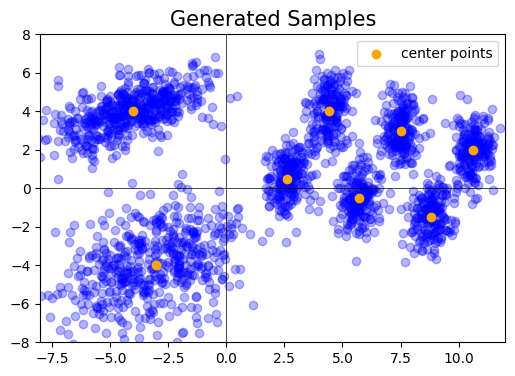

In [4]:
plt.figure(figsize=(6,4))

plt.title('Generated Samples', fontsize=15)

plt.hlines(0,-8,12, color='black', linewidth=0.5)
plt.vlines(0,-8,8, color='black', linewidth=0.5)

plt.scatter(samples[:,0], samples[:,1], c='blue', alpha=0.3)
plt.scatter(mean[:,0], mean[:,1], c='orange', label='center points')

plt.xlim(-8,12)
plt.ylim(-8,8)

plt.legend()

# Prototype Selection

Representative patterns (so called prototypes) are chosen to minimize the distance metric between the entire sample distribution and the distribution of prototypes.

In [5]:
from sklearn.metrics.pairwise import rbf_kernel
import sys

In [6]:
# reference: https://github.com/BeenKim/MMD-critic

def greedy_protos(K, candidate_indices, m):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    colsum = 2*np.sum(K, axis=0) / n
    selected = np.array([], dtype=int)

    f_list = []
    cond_list = []
    nsk = 0
    
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        lenS = len(selected)
        if lenS > 0:
            temp = K[selected, :][:, candidates]
            s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]
            s2array = s2array/(lenS + 1)
            s3array = s1array - s2array
        else:
            s3array = s1array - (np.abs(np.diagonal(K)[candidates]))
        
        max_idx = np.argmax(s3array)
        if lenS > 0:
            sk = np.sum(K[selected, :][:, selected])
            f = s3array[max_idx]/(lenS+1) - nsk/(lenS*(lenS+1)) + (1/(lenS**2)-1/((lenS+1)**2))*sk
            f_list.append(f)
        else:
            f_list.append(s3array[max_idx])
        
        argmax = candidates[max_idx]
        selected = np.append(selected, argmax)
        
        '''nsk: (2/n)*\sum{k([n],S)}'''
        nsk += s1array[max_idx]

    return candidate_indices[selected], f_list

In [7]:
%%time
kernel_matrix = rbf_kernel(samples, gamma=0.3)

CPU times: user 1.21 s, sys: 54.1 ms, total: 1.27 s
Wall time: 56.8 ms


In [8]:
print(kernel_matrix)

[[1.00000000e+00 2.76268448e-04 7.68902795e-01 ... 7.24451379e-23
  3.09054680e-25 4.69334438e-25]
 [2.76268448e-04 1.00000000e+00 2.19875493e-03 ... 5.28152300e-33
  6.24511565e-36 1.06886116e-35]
 [7.68902795e-01 2.19875493e-03 1.00000000e+00 ... 1.05101352e-25
  3.07906912e-28 4.82023899e-28]
 ...
 [7.24451379e-23 5.28152300e-33 1.05101352e-25 ... 1.00000000e+00
  8.63365266e-01 8.82433953e-01]
 [3.09054680e-25 6.24511565e-36 3.07906912e-28 ... 8.63365266e-01
  1.00000000e+00 9.99101027e-01]
 [4.69334438e-25 1.06886116e-35 4.82023899e-28 ... 8.82433953e-01
  9.99101027e-01 1.00000000e+00]]


In [9]:
n_samples = len(samples)
n_cluster = 8

In [10]:
selected, f_list = greedy_protos(kernel_matrix, np.arange(n_samples), n_cluster)
print(selected)

[  69 1890 1066 1433  576 1752 2062  748]


In [11]:
protos = samples[selected]

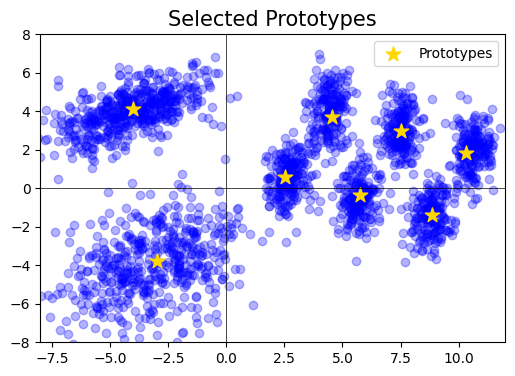

In [12]:
plt.figure(figsize=(6,4))

plt.title('Selected Prototypes', fontsize=15)

plt.hlines(0,-8,12, color='black', linewidth=0.5)
plt.vlines(0,-8,8, color='black', linewidth=0.5)

plt.scatter(samples[:,0], samples[:,1], c='blue', alpha=0.3)
plt.scatter(protos[:,0], protos[:,1], color='gold', s=120, marker='*', label='Prototypes')

plt.xlim(-8,12)
plt.ylim(-8,8)

plt.legend()